# Indonesian Summarizer Using mT5 (Multilingual T5)
Although there already exist various fine-tuned models for summarization, almost all of these are only suitable for English documents. So, we will train a summarizer model for summarizing text in Bahasa Indonesia.

In [1]:
pip install datasets rouge_score evaluate -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

## Prepare Data
We will use the XL-Sum dataset to create our summarizer. XL-Sum is a comprehensive and diverse dataset for abstractive summarization comprising 1 million professionally annotated article-summary pairs from BBC, extracted using a set of carefully designed heuristics. The dataset covers 44 languages, including Indonesia.

Link: https://github.com/csebuetnlp/xl-sum

In [3]:
from datasets import load_dataset

data_files = {"train": "/kaggle/input/xlsum-indo/indonesian_train.jsonl", "test": "/kaggle/input/xlsum-indo/indonesian_test.jsonl", "validation": "/kaggle/input/xlsum-indo/indonesian_val.jsonl"}
dataset = load_dataset("json", data_files=data_files)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-23bb0eb1692c6f1c/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 38242
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 4780
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 4780
    })
})

In [4]:
def show_samples(dataset, num_samples=1, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Text: {example['text']}'")
        print(f"'>> Summary: {example['summary']}'")

show_samples(dataset)



'>> Text: Bulan Januari lalu, militan ISIS membebaskan anggota sekte Yazidi yang mereka tahan. Diketahui bahwa mereka yang dilepaskan adalah orang-orang yang sudah berusia lanjut atau dalam keadaan sakit. Komandan pasukan Kurdi, Westa Rasul, menyatakan beberapa di antara yang dilepaskan adalah 'wanita dan anak-anak'. Puluhan ribu penganut sekte Yazidi dipaksa untuk mengungsi ketika ISIS menyerbu desa-desa mereka pada bulan Agustus tahun lalu. Ribuan dari mereka mengungsi hingga ke gunung-gunung di Irak utara. Kelompok militan ini mengutuk keimanan sekte Yazidi dan membunuh ratusan anggota komunitas ini. Perserikatan Bangsa-bangsa menyatakan kemungkinan bahwa ISIS melakukan pemusnahan massal atau genosida terhadap sekte Yazidi. Ribuan lain anggota sekte ini ditangkap dan ditahan. Kebanyakan dari mereka adalah perempuan yang dilaporkan dijual untuk dijadikan budak seks. Bulan Januari lalu, militan ISIS juga membebaskan pengikut sekte Yazidi dari tahanan mereka.'

'>> Summary: Kelompok 

## Preprocess Data
Our next task is to tokenize the data. We begin by loading the tokenizer associated with the pretrained model checkpoint. We will use mt5-small as our checkpoint. mT5 tokenizer is using SentencePiece ([Paper](https://arxiv.org/abs/1808.06226)) text tokenizer. 

In [5]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

  warnings.warn(


### Test The mT5 Tokenizer

In [6]:
inputs = tokenizer("Bryan makan nasi ayam, jangan ganggu!")
print(inputs)
inputs = tokenizer.convert_ids_to_tokens(inputs.input_ids)
print(inputs)

{'input_ids': [259, 65561, 13793, 55886, 44986, 261, 259, 18578, 259, 52744, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

['▁', 'Bryan', '▁makan', '▁nasi', '▁ayam', ',', '▁', 'jangan', '▁', 'ganggu', '!', '</s>']


### Apply Truncation
We need to apply truncation to both the reviews and their titles to ensure we don’t pass excessively long inputs to our model.

In [7]:
max_input_length = 512
max_target_length = 64

def tokenize_function(data):
    model_inputs = tokenizer(
        data['text'],
        max_length=max_input_length,
        truncation=True,
    )
    
    labels = tokenizer(
        data['summary'], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)
show_samples(dataset)

  0%|          | 0/39 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]



'>> Text: Bulan Januari lalu, militan ISIS membebaskan anggota sekte Yazidi yang mereka tahan. Diketahui bahwa mereka yang dilepaskan adalah orang-orang yang sudah berusia lanjut atau dalam keadaan sakit. Komandan pasukan Kurdi, Westa Rasul, menyatakan beberapa di antara yang dilepaskan adalah 'wanita dan anak-anak'. Puluhan ribu penganut sekte Yazidi dipaksa untuk mengungsi ketika ISIS menyerbu desa-desa mereka pada bulan Agustus tahun lalu. Ribuan dari mereka mengungsi hingga ke gunung-gunung di Irak utara. Kelompok militan ini mengutuk keimanan sekte Yazidi dan membunuh ratusan anggota komunitas ini. Perserikatan Bangsa-bangsa menyatakan kemungkinan bahwa ISIS melakukan pemusnahan massal atau genosida terhadap sekte Yazidi. Ribuan lain anggota sekte ini ditangkap dan ditahan. Kebanyakan dari mereka adalah perempuan yang dilaporkan dijual untuk dijadikan budak seks. Bulan Januari lalu, militan ISIS juga membebaskan pengikut sekte Yazidi dari tahanan mereka.'

'>> Summary: Kelompok 

### Remove Unused Columns

In [13]:
tokenized_datasets = tokenized_datasets.remove_columns(
    dataset["train"].column_names
) 
tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels']}

## Metrics
$$ Recall = \frac {NumberOfOverlappingWords}{TotalNumberOfWordsInReferenceSummary}$$
$$ Precision = \frac {NumberOfOverlappingWords}{TotalNumberOfWordsInGeneratedSummary}$$
$$ RougeScore = \frac {2 * Recall * Precision}{Recall + Precision} $$

In [8]:
import evaluate

rouge_score = evaluate.load("rouge")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
import numpy as np
from nltk.tokenize import sent_tokenize

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    return {k: round(v, 4) for k, v in result.items()}  

## Fine-tune Model
The majority of Transformer models for summarization (e.g. GPT-2, T5, BART) are monolingual. Fortunately, there is a class of multilingual Transformer models, like mT5. These models are pretrained using language modeling, but instead of training on a corpus of one language, they are trained jointly on texts in over 100 languages at once (multilingual C4 dataset).

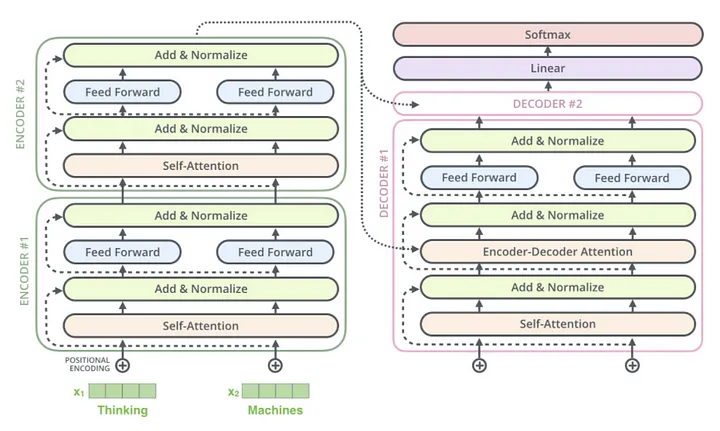

In [9]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

### Define Data Collator
We will prepare our batches because during decoding we need to shift the labels to the right by one. We also need to pad the inputs and the labels to have the same length for each batch. Luckily, DataCollatorForSeq2Seq collator that will do that for us.

In [12]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [14]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  1022,  89296,    502,  ...,      0,      0,      0],
        [  1408,  53774,    259,  ...,    274, 154539,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[  5483,   4513,   1294,  18624,   5990,    906,    314,   1224, 144072,
           2941,  11303,    266,   4481,    321,  34710,  89800,    301,  11362,
          38396,    261,  13968,  32071,    261,    303,   4561,    259,   6695,
            603,   5204,   1150,  35153,    719,  81891,    264,    280,  85393,
            260,    320, 191399,    647,    911,   2855,    767, 132438,    260,
              1,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100],
        [ 43274,   2851,  44606,    416, 132023,    502,    851,  15449,   9102,
            818,  99569,    314,   1085,    259,  21474,   1408,  53774,   6765,
          1

### Begin Training Iteration

In [10]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 4

logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,                      # Limit the maximum number of checkpoint saved during training
    num_train_epochs=num_train_epochs,       
    predict_with_generate=True,              # To indicate that we should generate summaries during evaluation for computing ROUGE scores
    logging_steps=logging_steps,             # Show the training loss with every epoch
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
) 

trainer.train()
trainer.save_model("./mT5-IndoSum")

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,2.617027,0.207600,0.067000,0.174100,0.174600
2,3.668800,2.505572,0.216100,0.071300,0.181900,0.182600
3,3.668800,2.470617,0.217200,0.072500,0.183400,0.183900
4,3.027900,2.455400,0.217800,0.072200,0.183700,0.184300


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

  warnings.warn('Was asked to gather along dimension 0, but all '

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

  warnings.warn('Was asked to gather along dimension 0, but all '

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

  warnings.warn('Was asked to gather along dimension 0, but all '

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will ins

## Inference

### Load Saved Model

In [1]:
from transformers import pipeline

model_path = "/kaggle/input/mt5-pretrained-xlsum/mt5-xlsum"
summarizer = pipeline("summarization", model=model_path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Test Data

In [2]:
from datasets import load_dataset

data_files = {"test": "/kaggle/input/xlsum-indo/indonesian_test.jsonl"}
dataset = load_dataset("json", data_files=data_files)
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-5a833fb171eb6f0a/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 4780
    })
})

In [7]:
def print_summary(idx):
    text = dataset["test"][idx]["text"]
    ref = dataset["test"][idx]["summary"]
    summary = summarizer(text, max_length=50)[0]["summary_text"]
    print(f"'>>> text: {text}'")
    print(f"\n'>>> Reference Summary: {ref}'")
    print(f"\n'>>> Predicted Summary: {summary}'")

for i in range(5):
    print_summary(i)
    print()
    print("===============================================================================================================")
    print()

'>>> text: Still Life, Vase with Daisies, and Poppies dibuat beberapa bulan sebelum van Gogh meninggal. Still Life, Vase with Daisies, and Poppies melampaui perkiraan sebelumnya US$50 juta pada pelelangan di Sotheby. Lukisan Van Gogh dibuat di rumah dokter Prancisnya hanya beberapa bulan sebelum dirinya meninggal di tahun 1890. Karyanya ini adalah satu dari beberapa lukisannya yang terjual saat Van Gogh masih hidup. Rekor penjualan pelukis Belanda pada balai lelang adalah US$82,5 juta lewat Portrait of Dr Gachet. Lukisan tentang dokternya ini terjual pada tahun 1990. Pada pelelangan ini patung Alberto Giacometti dari tahun1951 terjual seharga lebih dari US$100 juta, di bawah rekor karya seniman Swiss itu senilai US$104,3 juta. Sementara pematung Amedeo Modigliani mencatat rekor baru lewat Tete patung kepala yang dibuat di tahun 1911-1912 dari batu kapur terjual lebih US$70 juta.'

'>>> Reference Summary: Sebuah mahakarya Vincent van Gogh, yang dilukis pada akhir kehidupannya, terjual d

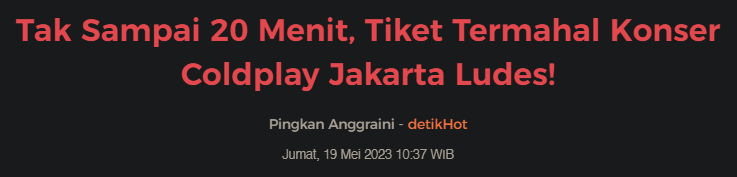

In [9]:
text = """Penjualan tiket konser Coldplay di Jakarta kembali dibuka hari ini. \
Penjualan ini dilakukan untuk semua publik. detikcom mencoba masuk ke dalam antrian pembelian. \
Rupanya, belum sampai 20 menit tiket Coldplay kategori Ultimate Experience sudah sold out, \
Jumat (19/5/2023). Kategori ini dibanderol dengan harga yang fantastis dan paling mahal senilai Rp 11 juta. \
"Ayo yang mau, dm," cuit akun @jcrno*** di Twitter. \
Unggahan itu langsung diserbu netizen. Banyak dari mereka langsung ingin ikut jasa titip itu. \
Pada unggahan itu juga menjelaskan status kategori My Universe yang kini sudah full booked. Diketahui, kategori ini dibandrol dengan harga Rp 5,7 juta. \
Lalu ada juga kategori CAT 5A dan 5B yang sudah full booked. Sementara itu sisanya masih tersedia. \
Diketahui, penjualan tiket Coldplay sejak 17 Mei 2023 memang menjadi hal yang paling disorot publik. Penjualan ini memang terbilang cukup cepat. \
Pada 17 Mei 2023 tiket Coldplay dijual secara presale dan sudah sold out sebelum 18 Mei 2023."""
print("Text:", text)
print()
summary = summarizer(text, max_length=100)[0]["summary_text"]
print("Summary:", summary)

Text: Penjualan tiket konser Coldplay di Jakarta kembali dibuka hari ini. Penjualan ini dilakukan untuk semua publik. detikcom mencoba masuk ke dalam antrian pembelian. Rupanya, belum sampai 20 menit tiket Coldplay kategori Ultimate Experience sudah sold out, Jumat (19/5/2023). Kategori ini dibanderol dengan harga yang fantastis dan paling mahal senilai Rp 11 juta. "Ayo yang mau, dm," cuit akun @jcrno*** di Twitter. Unggahan itu langsung diserbu netizen. Banyak dari mereka langsung ingin ikut jasa titip itu. Pada unggahan itu juga menjelaskan status kategori My Universe yang kini sudah full booked. Diketahui, kategori ini dibandrol dengan harga Rp 5,7 juta. Lalu ada juga kategori CAT 5A dan 5B yang sudah full booked. Sementara itu sisanya masih tersedia. Diketahui, penjualan tiket Coldplay sejak 17 Mei 2023 memang menjadi hal yang paling disorot publik. Penjualan ini memang terbilang cukup cepat. Pada 17 Mei 2023 tiket Coldplay dijual secara presale dan sudah sold out sebelum 18 Mei 20

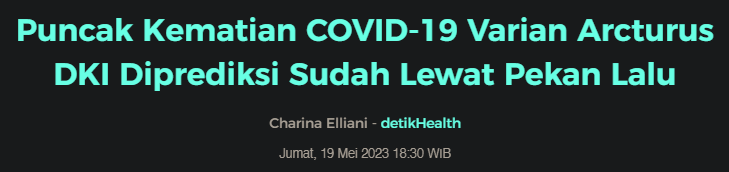

In [10]:
text = """Jakarta - Puncak kematian COVID-19 varian Arcturus di DKI Jakarta diyakini sudah terlewati minggu lalu. Kini, tren kasus juga tercatat mengalami penurunan. Hal ini disampaikan oleh Kepala Seksi Surveilans Imunisasi Dinas Kesehatan DKI Jakarta dr Ngabila Salama. \
"Dalam empat hari terakhir, tanggal 15 sampai 18 Mei 2023, terdapat 518 kasus positif baru dan 6 kasus kematian baru. Jika dibandingkan pada periode yang sama minggu lalu, terdapat 12 kasus positif baru dan 1.942 kematian baru," jelas dr Ngabila kepada detikcom Jumat (19/5/2023). \
"Artinya kondisinya sudah jauh membaik dan lebih terkendali," sambungnya. \
Meski terdapat penurunan kasus yang cukup signifikan dan status kedaruratan COVID-19 global sudah resmi dicabut oleh Organisasi Kesehatan Dunia (WHO), tidak menutup kemungkinan peningkatan kasus COVID-19 tetap dapat terjadi secara periodik, dalam tiga sampai enam bulan sekali, layaknya kasus influenza atau penyakit menular musiman lain. \
"Data Long COVID pada anak dan dewasa juga minim. Kematian pada anak dengan COVID-19 sangat rendah tahun 2023, 0,16 persen dari total kematian," paparnya lebih lanjut. \
dr Ngabila tetap mengimbau masyarakat untuk menjaga imunitas tubuh dengan menerapkan pola hidup yang sehat. Ia juga mendorong masyarakat untuk melengkapi kewajiban vaksinasi lengkap untuk mencegah komplikasi dan kematian. \
"Cukup makan, tidur, olahraga, dan tidak stres, cegah komplikasi dan kematian dengan vaksinasi lengkap dan deteksi dini, serta kontrol komorbid rutin dengan obat-obatan," jelasnya. \
Terkait stok vaksin COVID-19 di DKI Jakarta saat ini, pemerintah menyediakan merek Indovac dan Zifivax untuk vaksinasi dosis 1, 2, booster pertama, hingga booster kedua bagi usia 18 tahun ke atas. Mengenai vaksinasi, dr Ngabila menyarankan ibu hamil untuk menunda vaksinasi karena belum adanya cukup data yang bisa memastikan keamanannya. \
"Vaksinasi tersedia di 44 puskesmas kecamatan, puskesmas kelurahan di Jakarta dan lokasi vaksin lainnya yang bekerja sama dengan puskesmas. Untuk lokasi, dapat dilihat di Instagram @dinkesdki," pungkasnya. \
"""
print("Text:", text)
print()
summary = summarizer(text, max_length=100)[0]["summary_text"]
print("Summary:", summary)

Text: Jakarta - Puncak kematian COVID-19 varian Arcturus di DKI Jakarta diyakini sudah terlewati minggu lalu. Kini, tren kasus juga tercatat mengalami penurunan. Hal ini disampaikan oleh Kepala Seksi Surveilans Imunisasi Dinas Kesehatan DKI Jakarta dr Ngabila Salama. "Dalam empat hari terakhir, tanggal 15 sampai 18 Mei 2023, terdapat 518 kasus positif baru dan 6 kasus kematian baru. Jika dibandingkan pada periode yang sama minggu lalu, terdapat 12 kasus positif baru dan 1.942 kematian baru," jelas dr Ngabila kepada detikcom Jumat (19/5/2023). "Artinya kondisinya sudah jauh membaik dan lebih terkendali," sambungnya. Meski terdapat penurunan kasus yang cukup signifikan dan status kedaruratan COVID-19 global sudah resmi dicabut oleh Organisasi Kesehatan Dunia (WHO), tidak menutup kemungkinan peningkatan kasus COVID-19 tetap dapat terjadi secara periodik, dalam tiga sampai enam bulan sekali, layaknya kasus influenza atau penyakit menular musiman lain. "Data Long COVID pada anak dan dewasa 

### Evaluate Baseline
A common baseline for text summarization is to simply take the first three sentences of an article, often called the lead-3 baseline.

In [11]:
from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])
 
print(three_sentence_summary(dataset["test"][1]["text"]))

Foto tanggal 6 Agustus ini memperlihatkan keluarga sedang berpisah sebelum naik ke bus yang akan membawa mereka kembali ke Suriah.
Pihak berwenang mengatakan migran tak terdaftar harus segera kembali ke lokasi tempat pendaftaran mereka, sebagai upaya untuk mengurangi tekanan terhadap kota Istanbul.
Namun beberapa migran Suriah ini mengatakan banyak dari mereka yang dideportasi ke Idlib di Suriah - di mana peperangan masih berlangsung sengit.


In [16]:
import evaluate

rouge_score = evaluate.load("rouge")

def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["text"]]
    return metric.compute(predictions=summaries, references=dataset["summary"])

import pandas as pd

score = evaluate_baseline(dataset["test"], rouge_score)
score

{'rouge1': 0.207251642462169,
 'rouge2': 0.05940683141836349,
 'rougeL': 0.14718668354436798,
 'rougeLsum': 0.17216684143525118}

### Evaluate The Model

In [26]:
from tqdm.notebook import tqdm
from transformers.pipelines.pt_utils import KeyDataset

def evaluate_baseline(dataset, metric):
    summaries = []
    for out in tqdm(summarizer(KeyDataset(dataset, "text"), batch_size=8, max_length=100)):
        summaries.append(out[0]["summary_text"])
    return metric.compute(predictions=summaries, references=dataset["summary"])

score = evaluate_baseline(dataset["test"], rouge_score)
score

  0%|          | 0/598 [00:00<?, ?it/s]



{'rouge1': 0.32781271456848915,
 'rouge2': 0.2868995105594555,
 'rougeL': 0.3271940595671437,
 'rougeLsum': 0.3198969192413504}